In [1]:
from pythtb import TBModel, WFArray, Mesh
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def set_model(t, delta, lmbd):
    lat = [[1]]
    orb = [[0], [1/3], [2/3]]
    model = TBModel(1, 1, lat, orb)
    model.set_hop(t, 0, 1, [0])
    model.set_hop(t, 1, 2, [0])
    model.set_hop(t, 2, 0, [1])
    onsite_0 = delta * -np.cos(2*np.pi * (lmbd - 0/3))
    onsite_1 = delta * -np.cos(2*np.pi * (lmbd - 1/3))
    onsite_2 = delta * -np.cos(2*np.pi * (lmbd - 2/3))
    model.set_onsite([onsite_0, onsite_1, onsite_2])
    return model

In [3]:
# Used for initializing the Mesh
ref_model = set_model(0,0,0)

mesh = Mesh(
    ref_model, axis_types=["k", "param"], axis_names=["kx", "lmbd"]
    )

In [4]:
mesh.build_full_grid(shape=(31, 21), gamma_centered=True)

In [5]:
wfa = WFArray(mesh)

In [6]:
fixed_params = {"t": -1.3, "delta": 2.0}
wfa.solve_mesh(set_model, fixed_params)

Auto-imposing PBC in mesh direction 0 for k-component 0


In [7]:
wfa.shape

(31, 21, 3, 3)

In [8]:
# compute integrated curvature
chern_0 = wfa.chern_num(state_idx=[0], plane=(0,1))
chern_1 = wfa.chern_num(state_idx=[1], plane=(0,1))
chern_2 = wfa.chern_num(state_idx=[2], plane=(0,1))
chern_01 = wfa.chern_num(state_idx=[0,1], plane=(0,1))
chern_012 = wfa.chern_num(state_idx=[0,1,2], plane=(0,1))

print("Chern numbers for rising fillings")
print(f"  Band  0     = {chern_0:5.2f}")
print(f"  Bands 0,1   = {chern_01:5.2f}")
print(f"  Bands 0,1,2 = {chern_012:5.2f}")
print("")
print("Chern numbers for individual bands")
print(f"  Band  0 = {chern_0:5.2f}")
print(f"  Band  1 = {chern_1:5.2f}")
print(f"  Band  2 = {chern_2:5.2f}")

Chern numbers for rising fillings
  Band  0     = -1.00
  Bands 0,1   =  1.00
  Bands 0,1,2 =  0.00

Chern numbers for individual bands
  Band  0 = -1.00
  Band  1 =  2.00
  Band  2 = -1.00


In [9]:
# length of chain, in unit cells
num_cells = 10
num_orb = 3 * num_cells

def finite_model_builder(t, delta, lmbd):
    model = set_model(t, delta, lmbd)
    model = model.cut_piece(num_cells, 0)
    return model

In [10]:
ref_model = finite_model_builder(0, 0, 0)
mesh = Mesh(ref_model, axis_types=["param"], axis_names=["lmbd"])
mesh.build_full_grid(shape=(241,))

In [11]:
wfa = WFArray(mesh)
wfa.solve_mesh(model_func=finite_model_builder, fixed_params=fixed_params)

In [12]:
x_expec = wfa.position_expectation(dir=0)

(0.0, 1.0)

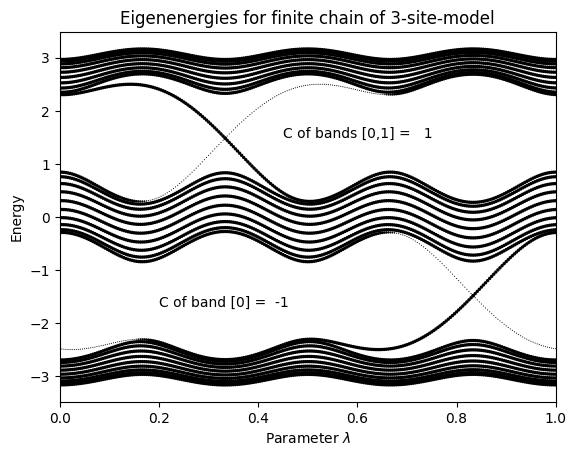

In [13]:
fig, ax = plt.subplots()

xcut = 2  # discard points below this
xfull = 4 # use symbols of full size above this

sizes = np.divide(
    x_expec - xcut,
    xfull - xcut,
    out=np.empty_like(x_expec, dtype=float),
    where=(xfull != xcut)
)

# clamp to [0.1, 1.0] in-place
np.clip(sizes, 0.1, 1.0, out=sizes)

all_lambda = mesh.get_param_points()
for o in range(num_orb):
    ax.scatter(all_lambda[:, 0], wfa.energies[:, o], edgecolors="none", s=sizes[:, o]*6.0, c="k")

# annotate gaps with bulk Chern numbers calculated earlier
ax.text(0.20, -1.7, f"C of band [0] = {chern_0:3.0f}")
ax.text(0.45, 1.5, f"C of bands [0,1] = {chern_01:3.0f}")

ax.set_title("Eigenenergies for finite chain of 3-site-model")
ax.set_xlabel(r"Parameter $\lambda$")
ax.set_ylabel("Energy")
ax.set_xlim(0.0, 1.0)